# Get the Rating Matrix

In [35]:
import pickle 

pickle_in = open("../datasets/rating_matrix.pickle","rb")
rating_matrix = pickle.load(pickle_in) 
pickle_in.close() 

In [36]:
type(rating_matrix)

dict

In [37]:
# !pip install apyori

In [38]:
# !pip install mlxtend  

In [39]:
# !pip install efficient-apriori

In [40]:
import pandas as pd 

data = pd.Series(rating_matrix).reset_index() 
data.columns = ["option_x", "option_y", "rating"] 

data.head() 

,option_x,option_y,rating
0,745321,666652,1
1,745321,751782,1
2,745321,751839,10
3,666652,751782,1
4,666652,751839,1


In [41]:
data_with_3 = pd.read_csv("../datasets/ratings_with_3_combinations.csv")[["rating", "bill"]]

data_with_3.head()

,rating,bill
0,1,"(745321, 666652)"
1,1,"(745321, 751782)"
2,10,"(745321, 751839)"
3,1,"(666652, 751782)"
4,1,"(666652, 751839)"


In [42]:
data_3_greater_1 = data_with_3[data_with_3.rating > 1] 

data_3_greater_1.head() 

,rating,bill
2,10,"(745321, 751839)"
5,151,"(751782, 751839)"
10,107,"(751873, 760125)"
11,12,"(772494, 754574)"
13,11,"(772494, 749358)"


In [43]:
len(data_with_3), len(data)

(5216080, 771062)

In [44]:
data.describe()

,option_x,option_y,rating
count,771062.000000,771062.000000,771062.000000
mean,735325.372226,735395.857417,2.418680
std,42364.768430,42085.392109,9.794105
min,16329.000000,10494.000000,1.000000
25%,714744.000000,714645.000000,1.000000
50%,751526.000000,751358.000000,1.000000
75%,760344.000000,760209.000000,2.000000
max,823758.000000,823758.000000,2254.000000


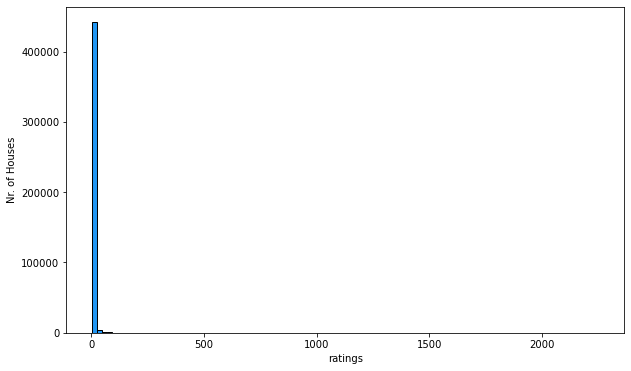

In [70]:
# If the distribution of the quantity is normal, then it should be standardized, otherwise, the data should be normalized.
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,6))
plt.hist(data_3_greater_1['rating'], bins=100, ec='black', color='#2196f3')
plt.xlabel('ratings')
plt.ylabel('Nr. of Houses')
plt.show()

In [72]:
max(data_3_greater_1.rating),  min(data_3_greater_1.rating)

(2254, 2)

c:\Users\melih.kacaman\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

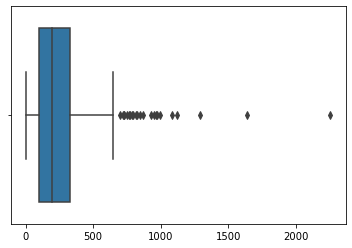

In [73]:
import seaborn as sns
sns.boxplot(data_3_greater_1['rating'].unique())

In [78]:
import numpy as np
data_3_greater_1_log = data_3_greater_1.copy() 
data_3_greater_1_log["rating"] = np.log(data_3_greater_1.rating) 

data_3_greater_1_log.head() 

,rating,bill
2,2.302585,"(745321, 751839)"
5,5.017280,"(751782, 751839)"
10,4.672829,"(751873, 760125)"
11,2.484907,"(772494, 754574)"
13,2.397895,"(772494, 749358)"


In [79]:
max(data_3_greater_1_log.rating),  min(data_3_greater_1_log.rating)

(7.720461694599722, 0.6931471805599453)

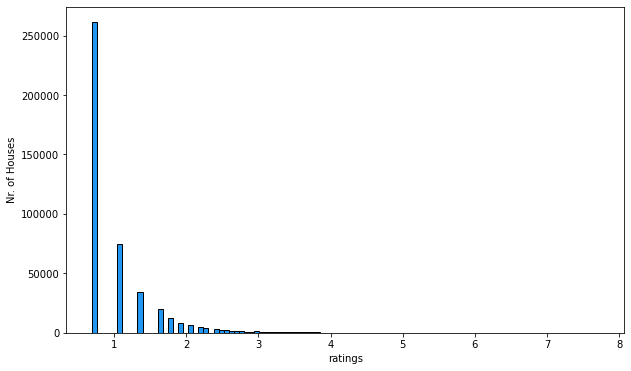

In [80]:
# If the distribution of the quantity is normal, then it should be standardized, otherwise, the data should be normalized.
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,6))
plt.hist(data_3_greater_1_log['rating'], bins=100, ec='black', color='#2196f3')
plt.xlabel('ratings')
plt.ylabel('Nr. of Houses')
plt.show()

c:\Users\melih.kacaman\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

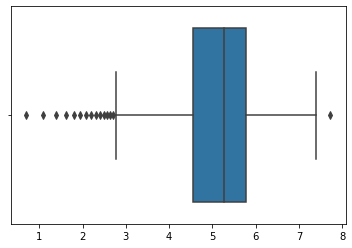

In [81]:
import seaborn as sns
sns.boxplot(data_3_greater_1_log['rating'].unique())

In [83]:
import numpy as np 
Q1 = np.percentile(data_3_greater_1_log['rating'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(data_3_greater_1_log['rating'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

print("data_3_greater_1_log has IQR:", IQR) 

data_3_greater_1_log has IQR: 0.6931471805599453


# Model 1: Matrix Factorization Using Keras 

#### Data Prep for MF 

In [84]:
data_3_greater_1_log.head() 

,rating,bill
2,2.302585,"(745321, 751839)"
5,5.017280,"(751782, 751839)"
10,4.672829,"(751873, 760125)"
11,2.484907,"(772494, 754574)"
13,2.397895,"(772494, 749358)"


In [87]:
data_3_greater_1_log.bill.unique().shape

(448529,)

In [89]:
data_3_greater_1_log.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 448529 entries, 2 to 5215140
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   rating  448529 non-null  float64
 1   bill    448529 non-null  object 
dtypes: float64(1), object(1)
memory usage: 26.4+ MB


In [122]:
from ast import literal_eval

data_3_greater_1_log.bill = data_3_greater_1_log.bill.apply(literal_eval) 
data_3_greater_1_log.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 448529 entries, 2 to 5215140
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   rating  448529 non-null  float64
 1   bill    448529 non-null  object 
dtypes: float64(1), object(1)
memory usage: 26.4+ MB


In [123]:
type(data_3_greater_1_log.bill.iat[0])

tuple

In [147]:
sublists_by_2 = list(filter(lambda x: len(x) == 2, data_3_greater_1_log.bill)) 
sublists_by_2[:2]

[(745321, 751839), (751782, 751839)]

In [49]:
from sklearn.utils import shuffle 
from keras.models import Model 
from keras.layers import Input, Embedding, Dense, Flatten, Concatenate, Activation

N = len(data.option_x.unique()) 
M = len(data.option_y.unique()) 

data_shuffled = shuffle(data) 

# initialize the latent vector dimension 
K = 10 
mu = data.rating.mean() 
epochs = 25 

u = Input(shape=(1,))
m = Input(shape=(1,))

u_embedding = Embedding(N, K)(u) # u -> u_embdedding
m_embedding = Embedding(M, K)(m) # m -> m_embedding 

u_embedding = Flatten()(u_embedding) # (N, K)
m_embedding = Flatten()(m_embedding) # (N, K)

x = Concatenate()([u_embedding, m_embedding]) # (N, 2K)
x = Dense(400)(x)
x = Activation('relu')(x)
x = Dense(1)(x)

model = Model(inputs=[u, m], outputs=x)  # Function 1 fulfilled

In [50]:
from keras.optimizers import SGD

model.compile(
  loss='mse',
  optimizer=SGD(lr=0.08, momentum=0.9),
  metrics=['mse'],
)

c:\Users\melih.kacaman\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [51]:
# history_model = model.fit(
#     x= [data_shuffled.option_x.values, data_shuffled.option_y.values], 
#     y= data_shuffled.rating.values, 
#     batch_size=128, 
#     epochs=25
# )

# Model 2: Apriori (apyori Module)

In [52]:
data_3_greater_1

,rating,bill
2,10,"(745321, 751839)"
5,151,"(751782, 751839)"
10,107,"(751873, 760125)"
11,12,"(772494, 754574)"
13,11,"(772494, 749358)"
...,...,...
5211482,2,"(774694, 767718, 767721)"
5213307,2,"(774590, 774319)"
5213311,2,"(774469, 774590, 774319)"
5213576,2,"(764896, 786771, 774571)"


In [53]:
from apyori import apriori 

In [54]:
transactions = [] 

for index,row in data_greater_1.iterrows(): 
    transaction = [str(row.option_x), str(row.option_y)]

    for i in range(row.rating):
        transactions.append(transaction) 

In [55]:
associations = apriori(
    transactions,
    min_length = 2,
    min_support = 0.001,
    min_confidence = 0.001,
    min_lift = 0.001
)

associations = list(associations)
len(associations)

533

In [56]:
association = associations[100]
print(association)
print("support", association.support)
print(association.ordered_statistics)
print("right", association.ordered_statistics[0].items_add)
print("left", association.ordered_statistics[0].items_base)
print("confidence", association.ordered_statistics[0].confidence)
print("lift", association.ordered_statistics[0].lift)


RelationRecord(items=frozenset({'714981'}), support=0.0010121434775095435, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'714981'}), confidence=0.0010121434775095435, lift=1.0)])
support 0.0010121434775095435
[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'714981'}), confidence=0.0010121434775095435, lift=1.0)]
right frozenset({'714981'})
left frozenset()
confidence 0.0010121434775095435
lift 1.0


In [57]:
rules = [] 
for association in associations:
    if len(association.ordered_statistics) > 1: 
        rules.append(association)

In [58]:
len(rules)

4

In [59]:
rules

[RelationRecord(items=frozenset({'751581', '751600'}), support=0.001021120359793442, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'751581', '751600'}), confidence=0.001021120359793442, lift=1.0), OrderedStatistic(items_base=frozenset({'751581'}), items_add=frozenset({'751600'}), confidence=0.0792314836312979, lift=6.939267030030741), OrderedStatistic(items_base=frozenset({'751600'}), items_add=frozenset({'751581'}), confidence=0.0894319596409618, lift=6.93926703003074)]),
 RelationRecord(items=frozenset({'753517', '753600'}), support=0.0012432981963199272, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'753517', '753600'}), confidence=0.0012432981963199272, lift=1.0), OrderedStatistic(items_base=frozenset({'753517'}), items_add=frozenset({'753600'}), confidence=0.08947510094212652, lift=4.467295221524749), OrderedStatistic(items_base=frozenset({'753600'}), items_add=frozenset({'753517'}), confidence=0.0620751475311

In [60]:
import string 
transactions_with_3 = [] 

for index,row in data_3_greater_1.iterrows(): 
    transaction = list(tuple(map(int, row.bill.translate(str.maketrans("", "", string.punctuation)).split(" "))))
    
    transactions_with_3.append(transaction)

In [61]:
from apyori import apriori 

associations_with_3 = apriori(
    transactions,
    min_length = 2,
    min_support = 0.001,
    min_confidence = 0.001,
    min_lift = 0.001
)

associations_with_3 = list(associations_with_3)
len(associations_with_3)

533

# Model 3: Apriori (mlxtend Module)

In [62]:
from efficient_apriori import apriori 

In [63]:
transactions_with_3 = list(map(lambda x: tuple(x), transactions_with_3))

In [64]:
itemsets, rules = apriori(transactions_with_3, min_support=0.001, min_confidence=0.001)

In [65]:
# itemsets

In [66]:
rules

[{751600} -> {751581},
 {751581} -> {751600},
 {753600} -> {753517},
 {753517} -> {753600},
 {753609} -> {753600},
 {753600} -> {753609},
 {778629} -> {778581},
 {778581} -> {778629}]